#Camila Lima Ferreira de Souza - Ra: 2100218
#Daniela Alexandra da Silva- Ra: 2100282
#Julia Camila Matias de Araújo - Ra: 2100236
#Guilherme Silva Monteiro - Ra: 2100299

**negrito**#Entendimento dos Dados

-Qual o formato dos dados? ✅ CSV - 
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
              #Column                                       #Dtype  
---  ------ --------------  -----  
 0   INDICE                                                 int64  
 1   UTC - CARIMBO DE DATA E HORA - SEGUNDOS                int64  
 2   TEMPERATURA DO AR [C]                                  float64
 3   UMIDADE DO AR [%]                                      float64
 4   TVOC[ppb] TOTAL DE COMPOSTOS ORGANICOS                 int64  
 5   eCO2[ppm] CONCENTRAÇÃO EQUIVALENTE DE CO2              int64  
 6   H2 HIDROGENIO MOLECULAR BRUTO                          int64  
 7   GAS ETANOL BRUTO                                       int64  
 8   [hPa] PRESÃO DO AR                                     float64
 9   PM1.0 TAMANHO DO MATERIAL PARTICULADO                  float64
 10  PM2.5 TAMANHO DO MATERIAL PARTICULADO                  float64
 11  NC0.5 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO    float64
 12  NC1.0 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO    object 
 13  NC2.5 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO    object 
 14  CNT CONTADOR DE AMOSTRA                                int64  
 15  ALARME DE INCENDIO                                     int64  
dtypes: float64(6), int64(8), object(2)

– Quantos registros existem? ✅ 

  São 62630 linhas e 16 colunas.


– Qual campo é um candidato a alvo?  
  ALARME DE INCENDIO

– Quantos vazios existem em cada atributo?  
  NC1.0 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO    829
  NC2.5 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO    473

– Qual a distribuição de (DETECÇÃO FUMAÇA:) ?

#Sem risco de incendio 0 = 17873      
#Com risco de incendio 1 = 44757

In [ ]:
# leitura e transformação dos dados
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler, SMOTE

dataset = pd.read_csv('/content/smoke_detection_iot.csv', sep = ';') 

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 16 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   INDICE                                               62630 non-null  int64  
 1   UTC - CARIMBO DE DATA E HORA - SEGUNDOS              62630 non-null  int64  
 2   TEMPERATURA DO AR [C]                                62630 non-null  float64
 3   UMIDADE DO AR [%]                                    62630 non-null  float64
 4   TVOC[ppb] TOTAL DE COMPOSTOS ORGANICOS               62630 non-null  int64  
 5   eCO2[ppm] CONCENTRAÇÃO EQUIVALENTE DE CO2            62630 non-null  int64  
 6   H2 HIDROGENIO MOLECULAR BRUTO                        62630 non-null  int64  
 7   GAS ETANOL BRUTO                                     62630 non-null  int64  
 8   [hPa] PRESÃO DO AR                                   62630 non-nul

In [ ]:
dataset['ALARME DE INCENDIO'].groupby(by=dataset['ALARME DE INCENDIO']).count()

ALARME DE INCENDIO
0    17873
1    44757
Name: ALARME DE INCENDIO, dtype: int64

In [ ]:
dataset['ALVO'] = dataset['ALARME DE INCENDIO']

In [ ]:
dataset.drop(columns=['INDICE'],inplace= True)
dataset.drop(columns=['ALARME DE INCENDIO'],inplace= True)
dataset = dataset.drop('CNT CONTADOR DE AMOSTRA ', axis=1)
dataset = dataset.drop('UTC - CARIMBO DE DATA E HORA - SEGUNDOS', axis=1)

In [ ]:
#convertendo coluna para numerico
dataset['NC1.0 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO'] = pd.to_numeric(dataset['NC1.0 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO'], errors = 'coerce')
dataset['NC2.5 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO'] = pd.to_numeric(dataset['NC2.5 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO'], errors= 'coerce')

In [ ]:
#PREPARAÇÃO DOS DADOS
# Fazendo tratamento da coluna Umidade do Ar para nova coluna " UMIDADE_TR" minimo: 12:00  Max: 65.00
dataset['UMIDADE_TR']  = [12.00 if np.isnan(x) or x <=12.00 else x  for x in dataset['UMIDADE DO AR [%]']]
dataset['UMIDADE_TR']  = [65.00 if x >65.00 else x  for x in dataset['UMIDADE_TR']]
dataset['UMIDADE_TR']  = [(x-12.00)/(65.00-12.00) for x in dataset['UMIDADE_TR']]

# Fazendo tratamento da coluna Temperatura do Ar para nova coluna " TEMPERATURA_TR" minimo: (-5.65)   Max: 37.60
dataset['TEMPERATURA_TR']  = [(-5.65) if np.isnan(x) or x <=(-5.65) else x  for x in dataset['TEMPERATURA DO AR [C]']]
dataset['TEMPERATURA_TR']  = [37.60  if x >37.60 else x  for x in dataset['TEMPERATURA_TR']]
dataset['TEMPERATURA_TR']  = [(x-(-5.65))/(37.60-(-5.65)) for x in dataset['TEMPERATURA_TR']]

dataset['TOTAL DE COMPOSTOS ORGANICOS_TR']  = [353.55 if np.isnan(x) or x <=353.55 else x  for x in dataset['TVOC[ppb] TOTAL DE COMPOSTOS ORGANICOS ']]
dataset['TOTAL DE COMPOSTOS ORGANICOS_TR']  = [3530.55 if x >=3530.55 else x  for x in dataset['TOTAL DE COMPOSTOS ORGANICOS_TR']]
dataset['TOTAL DE COMPOSTOS ORGANICOS_TR']  = [(x-353.55)/(3530.55-353.55) for x in dataset['TOTAL DE COMPOSTOS ORGANICOS_TR']]

dataset['CO2_TR']  = [613 if np.isnan(x) or x <=613 else x  for x in dataset['eCO2[ppm] CONCENTRAÇÃO EQUIVALENTE DE CO2']]
dataset['CO2_TR']  = [727 if x >=727 else x  for x in dataset['CO2_TR']]
dataset['CO2_TR']  = [(x-613)/(727-613) for x in dataset['CO2_TR']]

dataset['HIDROGENIO_TR']  = [10700.00 if np.isnan(x) or x <=10700.00 else x  for x in dataset['H2 HIDROGENIO MOLECULAR BRUTO']]
dataset['HIDROGENIO_TR']  = [13000.00 if x >13000.00 else x  for x in dataset['HIDROGENIO_TR']]
dataset['HIDROGENIO_TR']  = [(x-10700.00)/(13000.00-10700.00) for x in dataset['HIDROGENIO_TR']]

dataset['ETANOL_TR']  = [19400.00 if np.isnan(x) or x <=19400.00 else x  for x in dataset['GAS ETANOL BRUTO']]
dataset['ETANOL_TR']  = [20300.00 if x >=20300.00 else x  for x in dataset['ETANOL_TR']]
dataset['ETANOL_TR']  = [(x-19400.00)/(20300.00-19400.00) for x in dataset['ETANOL_TR']]

dataset['PRESSAO_DO_AR_TR']  = [(x-930.850)/(939.860-930.850) for x in dataset['[hPa] PRESÃO DO AR']]

dataset['PM1.0_TR']  = [0 if np.isnan(x) or x <=0 else x for x in dataset['PM1.0 TAMANHO DO MATERIAL PARTICULADO']]
dataset['PM1.0_TR']  = [100.00 if x >=100.00 else x  for x in dataset['PM1.0_TR']]
dataset['PM1.0_TR']  = [(x-0)/(100.00-0) for x in dataset['PM1.0_TR']]

dataset['PM2.5_TR']  = [0 if np.isnan(x) or x <=0 else x for x in dataset['PM2.5 TAMANHO DO MATERIAL PARTICULADO']]
dataset['PM2.5_TR']  = [100.00 if x >=100.00 else x for x in dataset['PM2.5_TR']]
dataset['PM2.5_TR']  = [(x-0)/(100.00-0) for x in dataset['PM2.5_TR']]

dataset['NC0.5_TR']  = [0 if np.isnan(x) or x <=0 else x for x in dataset['NC0.5 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO']]
dataset['NC0.5_TR']  = [100.00 if x >=100.00 else x  for x in dataset['NC0.5_TR']]
dataset['NC0.5_TR']  = [(x-0)/(100.00-0) for x in dataset['NC0.5_TR']]

dataset['NC1.0_TR']  = [0 if np.isnan(x) or x <=0 else x for x in dataset['NC1.0 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO']]
dataset['NC1.0_TR']  = [1000.00 if x >=1000.00 else x  for x in dataset['NC1.0_TR']]
dataset['NC1.0_TR']  = [(x-0)/(1000.00-0) for x in dataset['NC1.0_TR']]

dataset['NC2.5_TR']  = [0 if np.isnan(x) or x <=0 else x for x in dataset['NC2.5 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO']]
dataset['NC2.5_TR']  = [1000.00 if x >=1000.00 else x  for x in dataset['NC2.5_TR']]
dataset['NC2.5_TR']  = [(x-0)/(1000.00-0) for x in dataset['NC2.5_TR']]


In [ ]:
dataset.fillna(0)

,TEMPERATURA DO AR [C],UMIDADE DO AR [%],TVOC[ppb] TOTAL DE COMPOSTOS ORGANICOS,eCO2[ppm] CONCENTRAÇÃO EQUIVALENTE DE CO2,H2 HIDROGENIO MOLECULAR BRUTO,GAS ETANOL BRUTO,[hPa] PRESÃO DO AR,PM1.0 TAMANHO DO MATERIAL PARTICULADO,PM2.5 TAMANHO DO MATERIAL PARTICULADO,NC0.5 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO,...,TOTAL DE COMPOSTOS ORGANICOS_TR,CO2_TR,HIDROGENIO_TR,ETANOL_TR,PRESSAO_DO_AR_TR,PM1.0_TR,PM2.5_TR,NC0.5_TR,NC1.0_TR,NC2.5_TR
0,20.000,57.36,0,400,12306,18520,939.735,0.00,0.00,0.00,...,0.000000,0.0,0.698261,0.0,0.986127,0.0000,0.0000,0.0000,0.000000,0.000000
1,20.015,56.67,0,400,12345,18651,939.744,0.00,0.00,0.00,...,0.000000,0.0,0.715217,0.0,0.987125,0.0000,0.0000,0.0000,0.000000,0.000000
2,20.029,55.96,0,400,12374,18764,939.738,0.00,0.00,0.00,...,0.000000,0.0,0.727826,0.0,0.986459,0.0000,0.0000,0.0000,0.000000,0.000000
3,20.044,55.28,0,400,12390,18849,939.736,0.00,0.00,0.00,...,0.000000,0.0,0.734783,0.0,0.986238,0.0000,0.0000,0.0000,0.000000,0.000000
4,20.059,54.69,0,400,12403,18921,939.744,0.00,0.00,0.00,...,0.000000,0.0,0.740435,0.0,0.987125,0.0000,0.0000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62625,18.438,15.79,625,400,13723,20569,936.670,0.63,0.65,4.32,...,0.085442,0.0,1.000000,1.0,0.645949,0.0063,0.0065,0.0432,0.000673,0.000015
62626,18.653,15.87,612,400,13731,20588,936.678,0.61,0.63,4.18,...,0.081350,0.0,1.000000,1.0,0.646837,0.0061,0.0063,0.0418,0.000652,0.000015
62627,18.867,15.84,627,400,13725,20582,936.687,0.57,0.60,3.95,...,0.086072,0.0,1.000000,1.0,0.647836,0.0057,0.0060,0.0395,0.000617,0.000014
62628,19.083,16.04,638,400,13712,20566,936.680,0.57,0.59,3.92,...,0.089534,0.0,1.000000,1.0,0.647059,0.0057,0.0059,0.0392,0.000611,0.000014


In [ ]:
print(dataset.isna().sum())

TEMPERATURA DO AR [C]                                    0
UMIDADE DO AR [%]                                        0
TVOC[ppb] TOTAL DE COMPOSTOS ORGANICOS                   0
eCO2[ppm] CONCENTRAÇÃO EQUIVALENTE DE CO2                0
H2 HIDROGENIO MOLECULAR BRUTO                            0
GAS ETANOL BRUTO                                         0
[hPa] PRESÃO DO AR                                       0
PM1.0 TAMANHO DO MATERIAL PARTICULADO                    0
PM2.5 TAMANHO DO MATERIAL PARTICULADO                    0
NC0.5 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO      0
NC1.0 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO    829
NC2.5 CONCENTRAÇÃO NÚMERICA DE MATERIAL PARTICULADO    473
ALVO                                                     0
UMIDADE_TR                                               0
TEMPERATURA_TR                                           0
TOTAL DE COMPOSTOS ORGANICOS_TR                          0
CO2_TR                                                  

In [ ]:
x = dataset[['UMIDADE_TR', 'TEMPERATURA_TR', 'TOTAL DE COMPOSTOS ORGANICOS_TR', 'CO2_TR','HIDROGENIO_TR', 'ETANOL_TR', 'PRESSAO_DO_AR_TR', 'PM1.0_TR', 'PM2.5_TR', 'NC0.5_TR', 'NC1.0_TR', 'NC2.5_TR']]
x

,UMIDADE_TR,TEMPERATURA_TR,TOTAL DE COMPOSTOS ORGANICOS_TR,CO2_TR,HIDROGENIO_TR,ETANOL_TR,PRESSAO_DO_AR_TR,PM1.0_TR,PM2.5_TR,NC0.5_TR,NC1.0_TR,NC2.5_TR
0,0.855849,0.593064,0.000000,0.0,0.698261,0.0,0.986127,0.0000,0.0000,0.0000,0.000000,0.000000
1,0.842830,0.593410,0.000000,0.0,0.715217,0.0,0.987125,0.0000,0.0000,0.0000,0.000000,0.000000
2,0.829434,0.593734,0.000000,0.0,0.727826,0.0,0.986459,0.0000,0.0000,0.0000,0.000000,0.000000
3,0.816604,0.594081,0.000000,0.0,0.734783,0.0,0.986238,0.0000,0.0000,0.0000,0.000000,0.000000
4,0.805472,0.594428,0.000000,0.0,0.740435,0.0,0.987125,0.0000,0.0000,0.0000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
62625,0.071509,0.556948,0.085442,0.0,1.000000,1.0,0.645949,0.0063,0.0065,0.0432,0.000673,0.000015
62626,0.073019,0.561919,0.081350,0.0,1.000000,1.0,0.646837,0.0061,0.0063,0.0418,0.000652,0.000015
62627,0.072453,0.566867,0.086072,0.0,1.000000,1.0,0.647836,0.0057,0.0060,0.0395,0.000617,0.000014
62628,0.076226,0.571861,0.089534,0.0,1.000000,1.0,0.647059,0.0057,0.0059,0.0392,0.000611,0.000014


In [ ]:
# Base de dados - pytorch utiliza tensor! 
# Datset
import torch
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.x_data)

In [ ]:
y = dataset['ALVO']
y


0        0
1        0
2        0
3        0
4        0
        ..
62625    0
62626    0
62627    0
62628    0
62629    0
Name: ALVO, Length: 62630, dtype: int64

In [ ]:
# transformar em numpy para Dataset
x, y = np.array(x), np.array(y)

# criar dataset
dataset = CustomDataset(torch.from_numpy(x).float(), torch.from_numpy(y).float())

In [ ]:
# Convert the data from numpy array to a pandas dataframe
dataset = pd.DataFrame({'feature1': x[:, 0], 'feature2': x[:, 1], 'target': y})

# Check the target distribution
dataset['target'].value_counts(normalize = True)

1    0.714626
0    0.285374
Name: target, dtype: float64

In [ ]:
dataset['target'].value_counts()

1    44757
0    17873
Name: target, dtype: int64

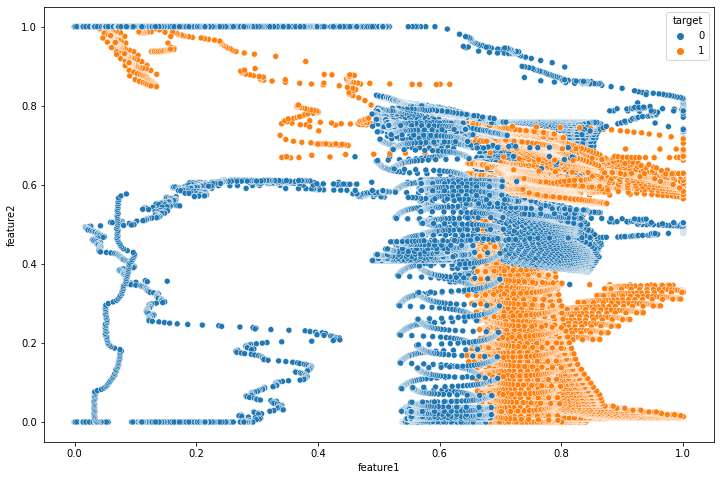

In [ ]:
# Visualizando dados 2 features
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = dataset)

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=88)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=88)

In [ ]:
# Check the number of majority and minority classes for the training dataset
print(sorted(Counter(y_train).items()))

[(0, 12868), (1, 32225)]


In [ ]:
# Randomly over sample em classe minoritária
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

# Check the number of records after over sampling
print(sorted(Counter(y_train_ros).items()))

[(0, 32225), (1, 32225)]


Text(0.5, 1.0, 'Random Over Sampling')

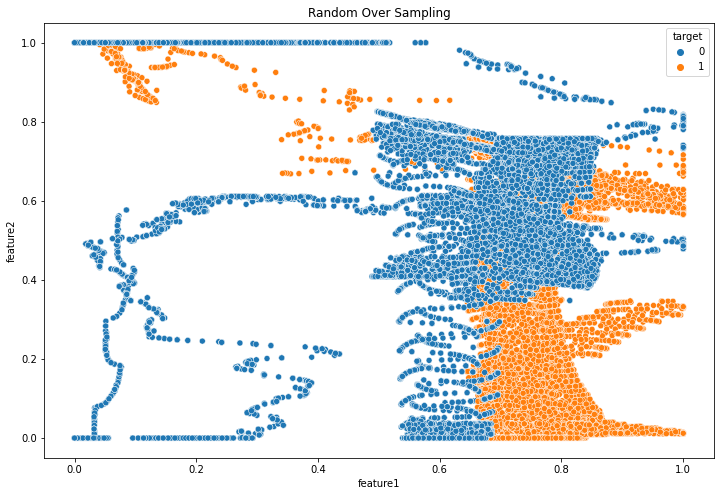

In [ ]:
# Convert the data from numpy array to a pandas dataframe
df_ros = pd.DataFrame({'feature1': X_train_ros[:, 0], 'feature2': X_train_ros[:, 1], 'target': y_train_ros})

# Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'feature1', y = 'feature2', hue = 'target', data = df_ros)
plt.title('Random Over Sampling')

In [ ]:
#Passando no dataset 
dataset = CustomDataset(torch.from_numpy(X_train_ros).float(), torch.from_numpy(y_train_ros).float())

In [ ]:
# Amostra balanceada no lote
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

contador=Counter(y_train_ros)

pesos_classes=1./np.array([contador[0],contador[1]])

pesos_amostra = np.array([pesos_classes[int(t)] for t in y_train_ros])
pesos_amostra=torch.from_numpy(pesos_amostra)
amostra = WeightedRandomSampler(pesos_amostra, len(pesos_amostra))

In [ ]:
#Quanto menor a Taxa de aprendizado - menor os passos que o modelo faz e fica mais otimizado/curto(tempo). 
# Hiperparâmetros
TAXA_APRENDIZADO = 0.01
#utilizado para rodar o conjunto em uma unica vez - melhora performance devido custo ser o mesmo.
BATCH = 64
EPOCAS = 90

In [ ]:
#Rede neural
import torch
from torch import nn
class MLP(nn.Module):
    #deixar a rede dinamica (atributos)
    def __init__(self, n_attrs):
        super(MLP, self).__init__()

        # Sequencia de tarefas da rede
        self.mlp_stack = nn.Sequential(                       
            nn.Linear(n_attrs, 9), # primeira camada - aplicar transformação de linear. n características e 9 neurônios          
            nn.ReLU(),  # ativar saída - transformar entre 0 e x            
            nn.Linear(9, 7), # segunda camada - aplicar transformação de linear. 7 neurônios
            nn.ReLU(),
            nn.Linear(7, 5), # terceira camada - aplicar transformação de linear. 5 neurônios
            nn.ReLU(), # ativar saída - transformar entre 0 e x
            nn.Linear(5, 3),  # quarta camada - aplicar transformação de linear. 3 neurônios 
            nn.ReLU(), # ativar saída - transformar entre 0 e x
            nn.Linear(3, 1),  # quinta camada - aplicar transformação de linear. (2 categorias)
            nn.Sigmoid() # ativação da rede - Sigmoid - saída entre 0 e 1
        )

    def forward(self, x):
        y = self.mlp_stack(x)
        return y

In [ ]:
# Carregar Dataset
dataset_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH,
    sampler=amostra
)

In [ ]:
# verificar gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
# inicialização do modelo
model = MLP(n_attrs=len(x[0]))
model.to(device)

Using cpu device


MLP(
  (mlp_stack): Sequential(
    (0): Linear(in_features=12, out_features=9, bias=True)
    (1): ReLU()
    (2): Linear(in_features=9, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
    (7): ReLU()
    (8): Linear(in_features=3, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

In [ ]:
# Treinamento
custo_fn = nn.BCELoss()#Entrada binária
#pegar o erro e propagar de volta para rede e otimizar o parametro do modelo"pesos"
optimizer = torch.optim.SGD(model.parameters(), lr=TAXA_APRENDIZADO)

# treinamento na rede neural
from sklearn.metrics import accuracy_score

valores_custo = []
valores_acuracia = []

for t in range(EPOCAS):
  custo_epoca = 0
  acuracia_epoca = 0

  print(f"\n-------------------------------\nÉpoca {t+1}")
  n = len(dataset_loader.dataset) # quantidade de registros

  #configurar modelo para treinamento
  model.train()
  # dividir o conjunto de treinamento em lotes (batches)
  for batch, (x_batch, y_batch) in enumerate(dataset_loader):

    # usar GPU
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    # fazer predição com modelo
    y_pred = model(x_batch)

    # calcular erro      #unsqueeze - adiciona uma dimensão
    custo = custo_fn(y_pred, y_batch.unsqueeze(1))

    # Backpropagation
    optimizer.zero_grad() # reiniciar gradiente
    custo.backward() # retropropagar o erro
    optimizer.step() # recalcular pesos
   
    custo_epoca +=  custo.item()

    # acuracia
    # y_pred tem uma saída para cada categoria (2 neurônios). 
    # torch.max() retorna o índice do maior valor
    # 0: catgoria 0
    # 1: categoria 1
    #_, y_pred_tags = torch.max(y_pred, dim = 1)
    acuracia_epoca += accuracy_score(y_batch.cpu(), torch.round(y_pred).detach().cpu()) # .cpu() remove o uso da GPU
  
  valores_custo.append(custo_epoca/len(dataset_loader))
  valores_acuracia.append(acuracia_epoca/len(dataset_loader))
  print(f"custo: {valores_custo[-1]:>5.4f}\t|\tacurácia: {valores_acuracia[-1]:>5.4f}")
  #saida sigmoid é algo entre 0 e 1
  


-------------------------------
Época 1
custo: 0.6975	|	acurácia: 0.4993

-------------------------------
Época 2
custo: 0.6932	|	acurácia: 0.4975

-------------------------------
Época 3
custo: 0.6931	|	acurácia: 0.5013

-------------------------------
Época 4
custo: 0.6932	|	acurácia: 0.4990

-------------------------------
Época 5
custo: 0.6931	|	acurácia: 0.4995

-------------------------------
Época 6
custo: 0.6931	|	acurácia: 0.5021

-------------------------------
Época 7
custo: 0.6931	|	acurácia: 0.5042

-------------------------------
Época 8
custo: 0.6931	|	acurácia: 0.5073

-------------------------------
Época 9
custo: 0.6930	|	acurácia: 0.5139

-------------------------------
Época 10
custo: 0.6930	|	acurácia: 0.5321

-------------------------------
Época 11
custo: 0.6929	|	acurácia: 0.5332

-------------------------------
Época 12
custo: 0.6927	|	acurácia: 0.5233

-------------------------------
Época 13
custo: 0.6924	|	acurácia: 0.5388

-------------------------------
É

Text(0.5, 1.0, 'Acurácia treinamento/Época')

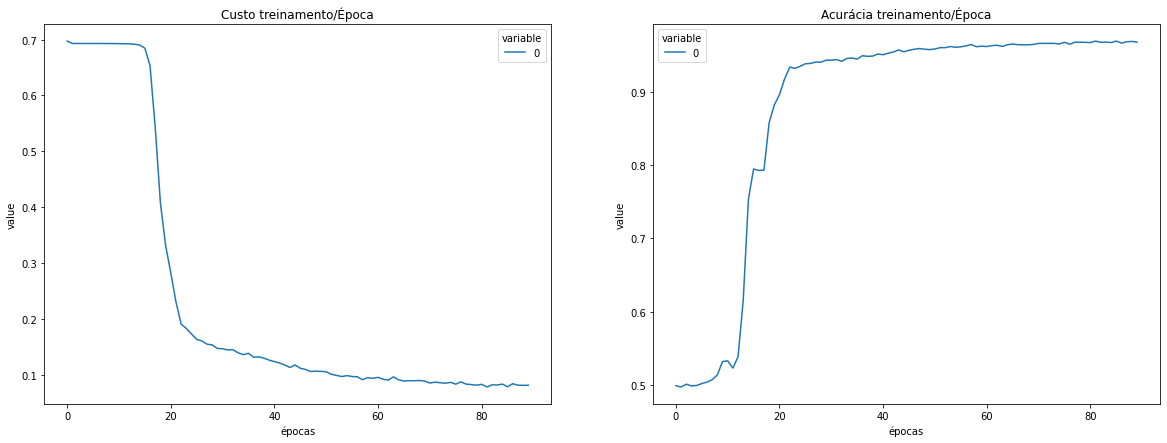

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
custo_df = pd.DataFrame(valores_custo).reset_index().melt(id_vars=['index']).rename(columns={"index":"épocas"})
acuracia_df = pd.DataFrame(valores_acuracia).reset_index().melt(id_vars=['index']).rename(columns={"index":"épocas"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))


sns.lineplot(data=custo_df, x = "épocas", y="value", hue="variable", ax=axes[0]).set_title('Custo treinamento/Época')
sns.lineplot(data=acuracia_df, x = "épocas", y="value", hue="variable", ax=axes[1]).set_title('Acurácia treinamento/Época')

In [ ]:
train_dataset = CustomDataset(torch.from_numpy(X_train_ros).float(), torch.from_numpy(y_train_ros).float())
val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [ ]:
# Amostra balanceada no lote
from collections import Counter
from torch.utils.data.sampler import WeightedRandomSampler

contador=Counter(y_train)

pesos_classes=1./np.array([contador[0],contador[1]])

pesos_amostra = np.array([pesos_classes[int(t)] for t in y_train])
pesos_amostra=torch.from_numpy(pesos_amostra)
amostra = WeightedRandomSampler(pesos_amostra, len(pesos_amostra))

In [ ]:
train_loader = DataLoader(dataset=train_dataset,  batch_size=BATCH, sampler=amostra)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
#Intanciando o treino com os pesos já ajustados
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
# inicialização do modelo
model = MLP(n_attrs=len(x[0]))
model.to(device)

custo_fn = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=TAXA_APRENDIZADO)

Using cpu device


In [ ]:
valores_custo = {
    "treinamento": [],
    "validacao": []
}

valores_acuracia = {
    "treinamento": [],
    "validacao": []
}

for t in range(EPOCAS):
  
  print(f"\n-------------------------------\nÉpoca {t+1}")
  n = len(train_loader.dataset) # quantidade de registros

  custo_epoca_train = 0
  acuracia_epoca_train = 0
  # treinamento
  model.train()
  # dividir o conjunto de treinamento em lotes (batches)
  for batch, (X_train_batch, y_train_batch) in enumerate(train_loader):
    
    # usar GPU
    X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)

    # fazer predição com modelo
    y_train_pred = model(X_train_batch)

    # calcular erro    
    custo = custo_fn(y_train_pred, y_train_batch.unsqueeze(1))

    # Backpropagation
    optimizer.zero_grad() # reiniciar gradiente
    custo.backward() # retropropagar o erro
    optimizer.step() # recalcular pesos
   
    custo_epoca_train +=  custo.item()

    # acuracia
    #_, y_pred_tags_train = torch.max(y_train_pred, dim = 1)
    acuracia_epoca_train += accuracy_score(y_train_batch.cpu(), torch.round(y_train_pred).detach().cpu())
  
  # validacao

  with torch.no_grad():
        
    custo_epoca_val = 0
    acuracia_epoca_val = 0

    # configural modelo para validacao
    model.eval()
    for X_val_batch, y_val_batch in val_loader:     

      # usar GPU
      X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

      y_val_pred = model(X_val_batch)
                  
      custo_val = custo_fn(y_val_pred, y_val_batch.unsqueeze(1))
      
      custo_epoca_val += custo_val.item()

      # acuracia
      #_, y_pred_tags_val = torch.max(y_val_pred, dim = 1)
      acuracia_epoca_val += accuracy_score(y_val_batch.cpu(), torch.round(y_val_pred).detach().cpu())
  
  valores_custo['treinamento'].append(custo_epoca_train/len(train_loader))
  valores_custo['validacao'].append(custo_epoca_val/len(val_loader))

  valores_acuracia['treinamento'].append(acuracia_epoca_train/len(train_loader))
  valores_acuracia['validacao'].append(acuracia_epoca_val/len(val_loader))
  print('Treinamento')
  print(f"custo: {valores_custo['treinamento'][-1]:>5.4f}\t|\tacurácia: {valores_acuracia['treinamento'][-1]:>5.4f}")
  print('Validação')
  print(f"custo: {valores_custo['validacao'][-1]:>5.4f}\t|\tacurácia: {valores_acuracia['validacao'][-1]:>5.4f}")


-------------------------------
Época 1
Treinamento
custo: 0.6985	|	acurácia: 0.5023
Validação
custo: 0.6804	|	acurácia: 0.7146

-------------------------------
Época 2
Treinamento
custo: 0.6932	|	acurácia: 0.4989
Validação
custo: 0.6932	|	acurácia: 0.3858

-------------------------------
Época 3
Treinamento
custo: 0.6931	|	acurácia: 0.5080
Validação
custo: 0.6948	|	acurácia: 0.2854

-------------------------------
Época 4
Treinamento
custo: 0.6930	|	acurácia: 0.5107
Validação
custo: 0.6920	|	acurácia: 0.7146

-------------------------------
Época 5
Treinamento
custo: 0.6930	|	acurácia: 0.5105
Validação
custo: 0.6952	|	acurácia: 0.2854

-------------------------------
Época 6
Treinamento
custo: 0.6930	|	acurácia: 0.5254
Validação
custo: 0.6948	|	acurácia: 0.2854

-------------------------------
Época 7
Treinamento
custo: 0.6930	|	acurácia: 0.5192
Validação
custo: 0.6935	|	acurácia: 0.2734

-------------------------------
Época 8
Treinamento
custo: 0.6929	|	acurácia: 0.5315
Validação
c

Text(0.5, 1.0, 'Acurácia treinamento/Época')

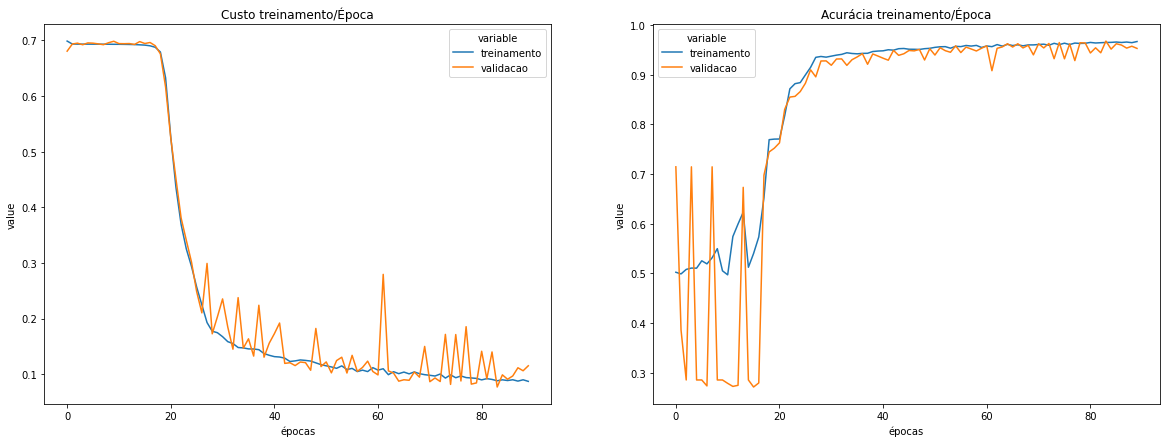

In [ ]:
custo_df = pd.DataFrame.from_dict(valores_custo).reset_index().melt(id_vars=['index']).rename(columns={"index":"épocas"})
acuracia_df = pd.DataFrame.from_dict(valores_acuracia).reset_index().melt(id_vars=['index']).rename(columns={"index":"épocas"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=custo_df, x = "épocas", y="value", hue="variable", ax=axes[0]).set_title('Custo treinamento/Época')
sns.lineplot(data=acuracia_df, x = "épocas", y="value", hue="variable", ax=axes[1]).set_title('Acurácia treinamento/Época')

In [ ]:
y_pred = []
with torch.no_grad():
  model.eval()
  for X_batch, _ in test_loader:
    X_batch = X_batch.to(device)
    y_test_pred = model(X_batch)
    #_, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred.append(torch.round(y_test_pred).cpu().numpy())
y_pred = [a.squeeze().tolist() for a in y_pred]


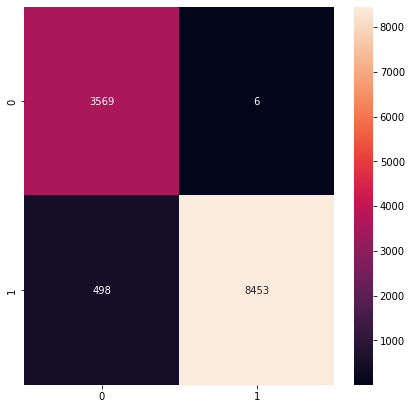

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred))

plt.subplots(figsize=(6.95,6.95))
sns.heatmap(confusion_matrix_df, annot=True, fmt='g')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      3575
           1       1.00      0.94      0.97      8951

    accuracy                           0.96     12526
   macro avg       0.94      0.97      0.95     12526
weighted avg       0.96      0.96      0.96     12526

